# Predicting Knowledge During Search with Decision Trees

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import graphviz
import random
import time
import warnings
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Ignore warnings
warnings.filterwarnings('ignore')

## Part 1a: Exploratory Data Analysis


### Load & Inspect Data

In [ ]:
# mount Google Drive
from google.colab import drive
import os

#Mount Google Drive
drive.mount('/content/drive', force_remount=True)

#Specify folder to access
project_folder = '/content/drive/My Drive/Colab Notebooks/Project3SAL/'

Mounted at /content/drive


In [ ]:
file_path = os.path.join(project_folder, "sal_lightning_combined.csv")

df = pd.read_csv(file_path)

In [ ]:
df.head()

,p_id,d_sex,d_age,d_field_of_study,d_no_sem,d_lang,k_mc_sum_t1,k_mc_sum_t2,kg_mc,essay_C1,...,DSSQ_mean,session_duration,num_pages_visited,unique_domains_visited,num_clicks,num_scrolls,total_interactions,num_browser_tabs,avg_time_active_per_tab,avg_time_per_page
0,1,2,25,Humanmedizin,2,farsi,7,8,1,5,...,6142857143,1726,43,10,43,1895,5582,111,14164.891892,40.139535
1,3,1,22,Jura,7,Deutsch,8,9,1,1,...,6.142.857.143,977,19,6,22,568,2437,60,12452.250000,51.421053
2,4,1,20,Kognitionswissenschaft,3,deutsch,6,6,0,3,...,6.714.285.714,1684,33,8,20,1218,8905,72,30962.875000,51.030303
3,5,1,23,Sozialpädagogik,9,deutsch,1,4,3,1,...,5.142.857.143,1552,19,6,46,412,3853,39,22691.846154,81.684211
4,6,1,25,"Englisch, Politik/Wirtschaft",10,Deutsch,6,7,1,1,...,5.714.285.714,1527,24,7,26,1450,4228,42,33764.142857,63.625000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   p_id                     114 non-null    int64  
 1   d_sex                    114 non-null    int64  
 2   d_age                    114 non-null    int64  
 3   d_field_of_study         114 non-null    object 
 4   d_no_sem                 114 non-null    int64  
 5   d_lang                   114 non-null    object 
 6   k_mc_sum_t1              114 non-null    int64  
 7   k_mc_sum_t2              114 non-null    int64  
 8   kg_mc                    114 non-null    int64  
 9   essay_C1                 114 non-null    int64  
 10  essay_C2                 114 non-null    int64  
 11  KG_essay                 114 non-null    int64  
 12  LGVT_speed               114 non-null    int64  
 13  LGVT_score               114 non-null    int64  
 14  WMC_Recalls              1

In [ ]:
print("Shape:", df.shape)

Shape: (114, 27)


In [ ]:
if 'DSSQ_mean' in df.columns:
    df.drop(columns='DSSQ_mean', inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   p_id                     114 non-null    int64  
 1   d_sex                    114 non-null    int64  
 2   d_age                    114 non-null    int64  
 3   d_field_of_study         114 non-null    object 
 4   d_no_sem                 114 non-null    int64  
 5   d_lang                   114 non-null    object 
 6   k_mc_sum_t1              114 non-null    int64  
 7   k_mc_sum_t2              114 non-null    int64  
 8   kg_mc                    114 non-null    int64  
 9   essay_C1                 114 non-null    int64  
 10  essay_C2                 114 non-null    int64  
 11  KG_essay                 114 non-null    int64  
 12  LGVT_speed               114 non-null    int64  
 13  LGVT_score               114 non-null    int64  
 14  WMC_Recalls              1

In [ ]:
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 p_id                       0
d_sex                      0
d_age                      0
d_field_of_study           0
d_no_sem                   0
d_lang                     0
k_mc_sum_t1                0
k_mc_sum_t2                0
kg_mc                      0
essay_C1                   0
essay_C2                   0
KG_essay                   0
LGVT_speed                 0
LGVT_score                 0
WMC_Recalls                0
WMC_Sentence               0
CRT_sum                    0
session_duration           0
num_pages_visited          0
unique_domains_visited     0
num_clicks                 0
num_scrolls                0
total_interactions         0
num_browser_tabs           0
avg_time_active_per_tab    0
avg_time_per_page          0
dtype: int64


### Handle Missing Values & Outliers

In [ ]:
df.dropna(inplace=True)

In [ ]:
numeric = ['session_duration','num_pages_visited','num_clicks','num_scrolls']
for col in numeric:
    lo, hi = df[col].quantile([.01, .99])
    df[col] = df[col].clip(lo, hi)

### Classify kg_mc into Low/Moderate/High

In [ ]:
def classify_knowledge_gain(kg):
    z = (kg - kg.mean())/kg.std()
    cats = np.empty(len(z), dtype=object)
    cats[z < -0.5]               = 'Low'
    cats[(z >= -0.5) & (z <= 0.5)] = 'Moderate'
    cats[z > 0.5]                = 'High'
    return cats

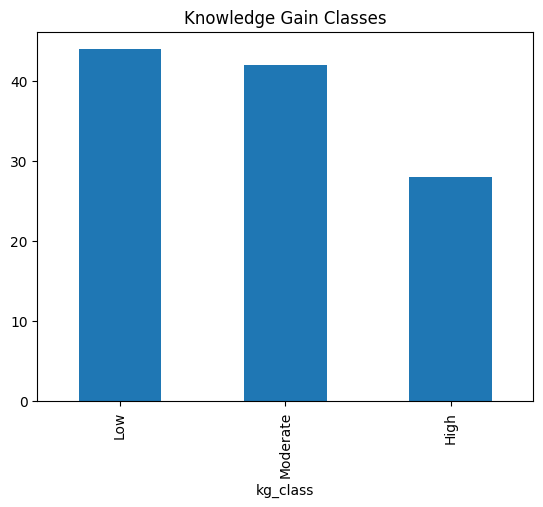

In [ ]:
df['kg_class'] = classify_knowledge_gain(df['kg_mc'])
df['kg_class'].value_counts().plot(kind='bar', title='Knowledge Gain Classes')
plt.show()

### Exploratory Visualizations

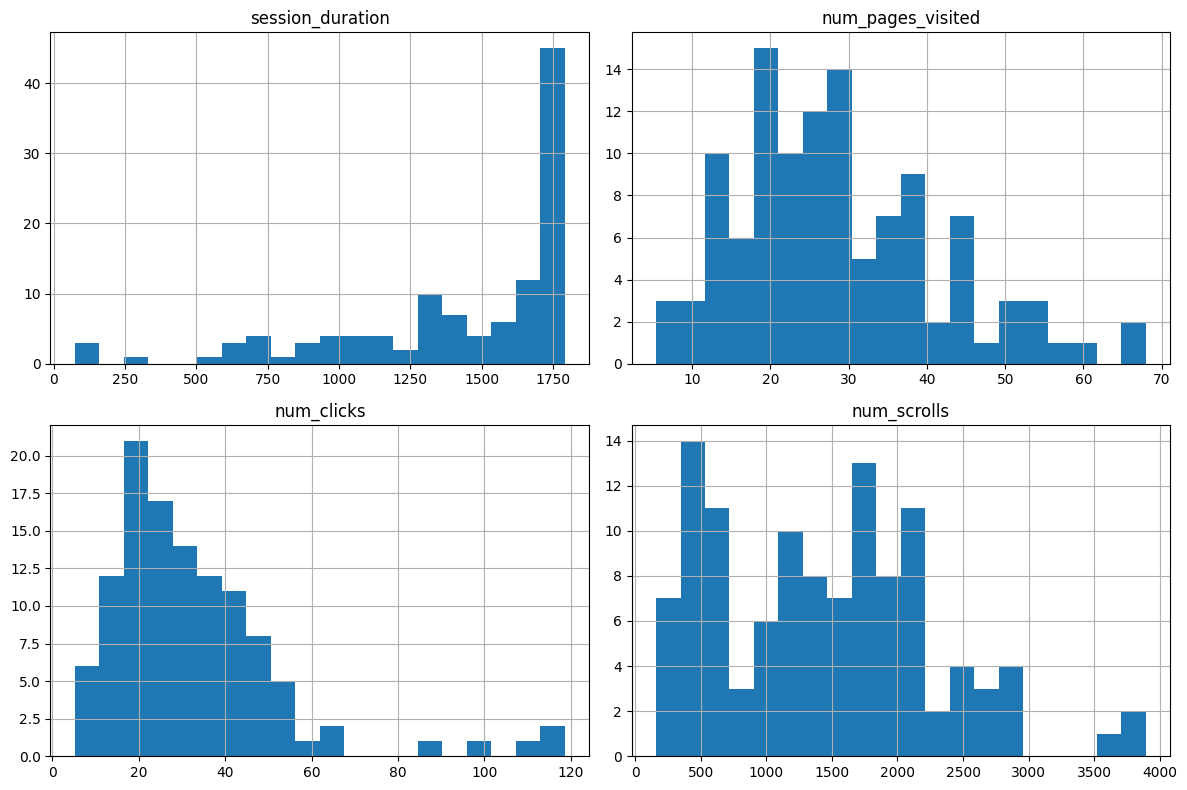

In [ ]:
# Distribution of numeric features

df[numeric].hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

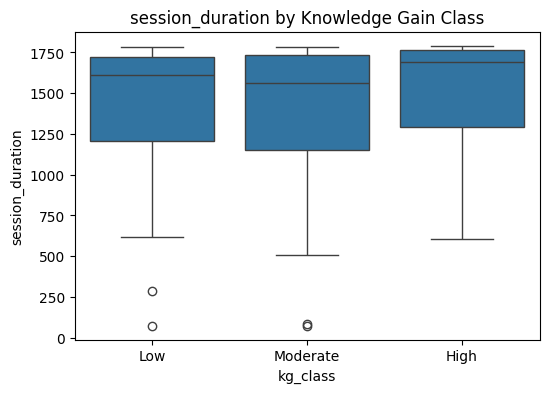

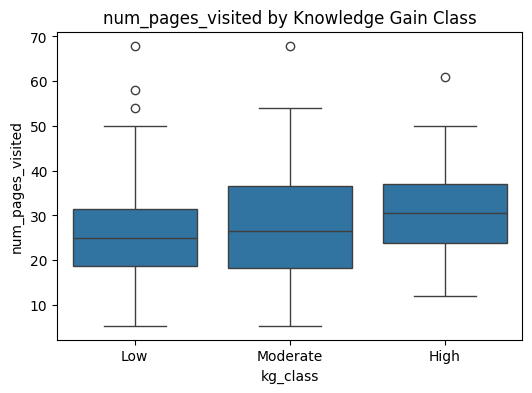

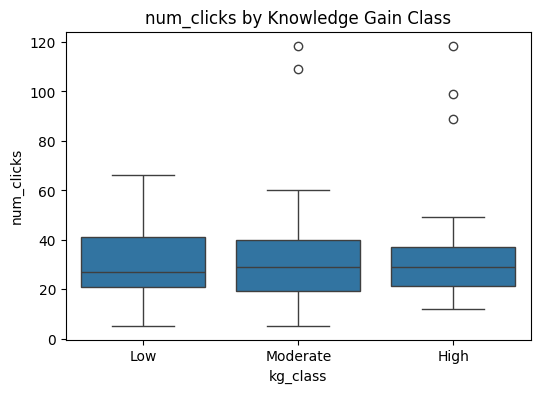

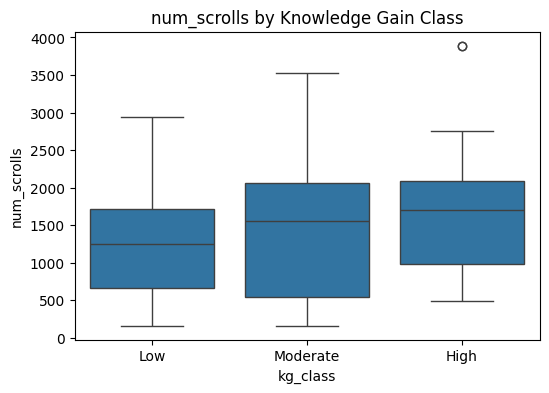

In [ ]:
# Boxplots of key behavior features by kg_class
for feat in numeric:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='kg_class', y=feat, data=df, order=['Low','Moderate','High'])
    plt.title(f"{feat} by Knowledge Gain Class")
    plt.show()

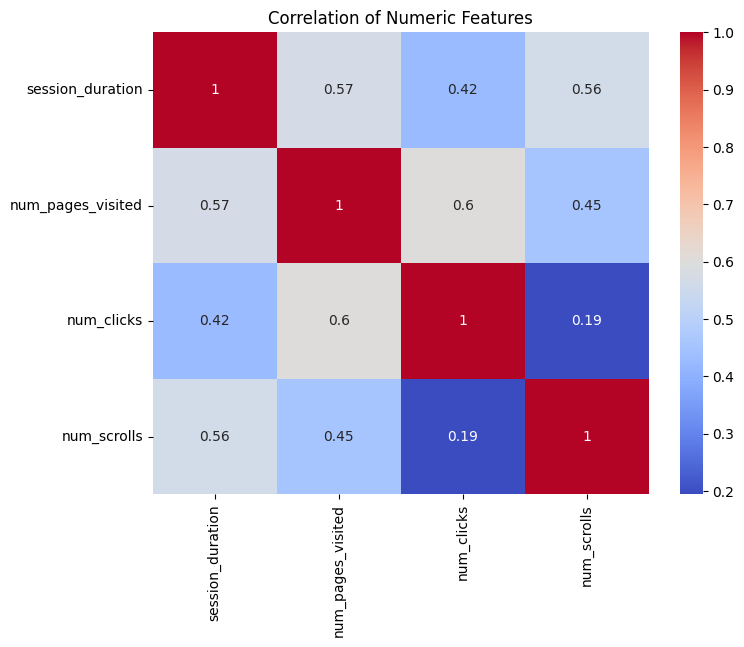

In [ ]:
# Pairwise scatter / correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation of Numeric Features")
plt.show()

### Train/Test Split & Preprocessing

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2,
                                     stratify=df['kg_class'],
                                     random_state=42)

In [ ]:
# Scale numeric features
scaler = StandardScaler()
train_df[numeric] = scaler.fit_transform(train_df[numeric])
test_df[numeric]  = scaler.transform(test_df[numeric])

In [ ]:
# One-hot encode categorical demographics
cat_feats = ['d_sex','d_field_of_study','d_lang']
train_df = pd.get_dummies(train_df,  columns=cat_feats, drop_first=True)
test_df  = pd.get_dummies(test_df,   columns=cat_feats, drop_first=True)

# Align train/test columns
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

In [ ]:
print("Training set shape:", train_df.shape)
print("Test set shape:",     test_df.shape)

Training set shape: (91, 100)
Test set shape: (23, 100)


## Part 1b: Decision Tree Implementation

Develop a decision tree classifier from scratch and then apply it to predict knowledge gain.

### Node & DecisionTreeClassifier Classes

In [ ]:
class Node:
    """A node in the decision tree."""
    def __init__(self, feature_idx=None, threshold=None, left=None,
                 right=None, value=None, gain=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.gain = gain

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=5, min_samples_split=2, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.tree = None

    def fit(self, X, y):
        """Builds the tree."""
        self.n_classes_ = len(np.unique(y))
        self.tree = self._split_node(X, y, depth=0)

    def predict(self, X):
        """Predict class labels for samples in X."""
        return np.array([self._predict_input(x, self.tree) for x in X])

    def _calculate_impurity(self, y):
        """Gini or entropy impurity of array y."""
        m = len(y)
        if m == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        probs = counts / m
        if self.criterion == 'gini':
            return 1 - np.sum(probs**2)
        # entropy
        return -np.sum([p * np.log2(p) for p in probs if p > 0])

    def _best_split(self, X, y):
        """Find feature and threshold that yields best information gain."""
        m, n = X.shape
        parent_impurity = self._calculate_impurity(y)
        best_gain, best_idx, best_thr = -1, None, None

        for idx in range(n):
            for thr in np.unique(X[:, idx]):
                left_mask = X[:, idx] <= thr
                right_mask = ~left_mask
                if (left_mask.sum() < self.min_samples_split
                        or right_mask.sum() < self.min_samples_split):
                    continue

                y_left, y_right = y[left_mask], y[right_mask]
                w_imp = (len(y_left)*self._calculate_impurity(y_left) +
                         len(y_right)*self._calculate_impurity(y_right)) / m
                gain = parent_impurity - w_imp
                if gain > best_gain:
                    best_gain, best_idx, best_thr = gain, idx, thr

        return best_idx, best_thr, best_gain

    def _split_node(self, X, y, depth):
        """Recursively splits nodes until stopping criteria."""
        # Stopping criteria
        if (depth >= self.max_depth or len(np.unique(y)) == 1
                or len(y) < self.min_samples_split):
            leaf_val = self._majority_class(y)
            return Node(value=leaf_val)

        idx, thr, gain = self._best_split(X, y)
        if idx is None:
            return Node(value=self._majority_class(y))

        left_mask = X[:, idx] <= thr
        left = self._split_node(X[left_mask], y[left_mask], depth+1)
        right = self._split_node(X[~left_mask], y[~left_mask], depth+1)
        return Node(feature_idx=idx, threshold=thr, left=left, right=right, gain=gain)

    def _majority_class(self, y):
        """Return the most common class label in y."""
        vals, counts = np.unique(y, return_counts=True)
        return vals[np.argmax(counts)]

    def _predict_input(self, x, node):
        """Traverse the tree to make a single prediction."""
        if node.value is not None:
            return node.value
        branch = node.left if x[node.feature_idx] <= node.threshold else node.right
        return self._predict_input(x, branch)


### Testing on Iris


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=3, min_samples_split=2, criterion='gini')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
dt_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", dt_accuracy)

Accuracy: 1.0


In [ ]:
print(classification_report(y_test, y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### Application to Knowledge-Gain Prediction


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Features and label
X_train = train_df.drop(columns=['p_id','kg_mc','kg_class']).values
X_test  = test_df.drop(columns=['p_id','kg_mc','kg_class']).values

le = LabelEncoder()
y_train = le.fit_transform(train_df['kg_class'])
y_test  = le.transform(test_df['kg_class'])

# Train & predict
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=5, criterion='entropy')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
# Evaluation
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test Accuracy: 0.8260869565217391


In [ ]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

        High       0.75      0.50      0.60         6
         Low       1.00      1.00      1.00         9
    Moderate       0.70      0.88      0.78         8

    accuracy                           0.83        23
   macro avg       0.82      0.79      0.79        23
weighted avg       0.83      0.83      0.82        23



## Part 2: Random Forest Analysis

Apply Random Forest using scikit-learn to predict knowledge gain and compare its performance with of decision tree implementation.

In [ ]:
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   p_id                     114 non-null    int64  
 1   d_sex                    114 non-null    int64  
 2   d_age                    114 non-null    int64  
 3   d_field_of_study         114 non-null    object 
 4   d_no_sem                 114 non-null    int64  
 5   d_lang                   114 non-null    object 
 6   k_mc_sum_t1              114 non-null    int64  
 7   k_mc_sum_t2              114 non-null    int64  
 8   kg_mc                    114 non-null    int64  
 9   essay_C1                 114 non-null    int64  
 10  essay_C2                 114 non-null    int64  
 11  KG_essay                 114 non-null    int64  
 12  LGVT_speed               114 non-null    int64  
 13  LGVT_score               114 non-null    int64  
 14  WMC_Recalls              1

In [ ]:
print("Shape:", df.shape)

Shape: (114, 27)


In [ ]:
# Drop DSSQ_mean if present
if 'DSSQ_mean' in df.columns:
    df.drop(columns='DSSQ_mean', inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   p_id                     114 non-null    int64  
 1   d_sex                    114 non-null    int64  
 2   d_age                    114 non-null    int64  
 3   d_field_of_study         114 non-null    object 
 4   d_no_sem                 114 non-null    int64  
 5   d_lang                   114 non-null    object 
 6   k_mc_sum_t1              114 non-null    int64  
 7   k_mc_sum_t2              114 non-null    int64  
 8   kg_mc                    114 non-null    int64  
 9   essay_C1                 114 non-null    int64  
 10  essay_C2                 114 non-null    int64  
 11  KG_essay                 114 non-null    int64  
 12  LGVT_speed               114 non-null    int64  
 13  LGVT_score               114 non-null    int64  
 14  WMC_Recalls              1

In [ ]:
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 p_id                       0
d_sex                      0
d_age                      0
d_field_of_study           0
d_no_sem                   0
d_lang                     0
k_mc_sum_t1                0
k_mc_sum_t2                0
kg_mc                      0
essay_C1                   0
essay_C2                   0
KG_essay                   0
LGVT_speed                 0
LGVT_score                 0
WMC_Recalls                0
WMC_Sentence               0
CRT_sum                    0
session_duration           0
num_pages_visited          0
unique_domains_visited     0
num_clicks                 0
num_scrolls                0
total_interactions         0
num_browser_tabs           0
avg_time_active_per_tab    0
avg_time_per_page          0
dtype: int64


In [ ]:
df.dropna(inplace=True)

In [ ]:
numeric = ['session_duration','num_pages_visited','num_clicks','num_scrolls']
for col in numeric:
    lo, hi = df[col].quantile([.01, .99])
    df[col] = df[col].clip(lo, hi)

In [ ]:
def classify_knowledge_gain(kg):
    z = (kg - kg.mean())/kg.std()
    cats = np.empty(len(z), dtype=object)
    cats[z < -0.5]               = 'Low'
    cats[(z >= -0.5) & (z <= 0.5)] = 'Moderate'
    cats[z > 0.5]                = 'High'
    return cats

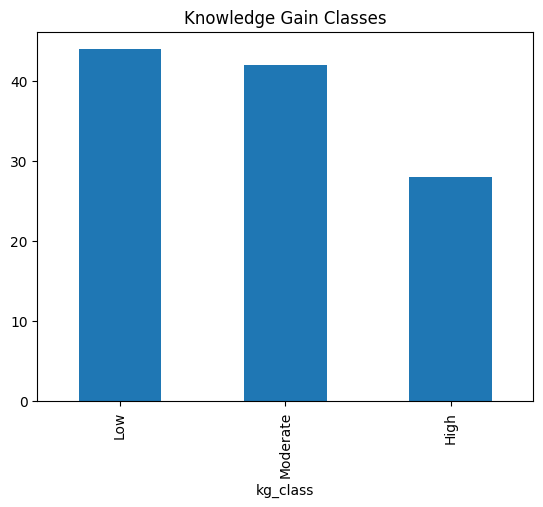

In [ ]:
df['kg_class'] = classify_knowledge_gain(df['kg_mc'])
df['kg_class'].value_counts().plot(kind='bar', title='Knowledge Gain Classes')
plt.show()

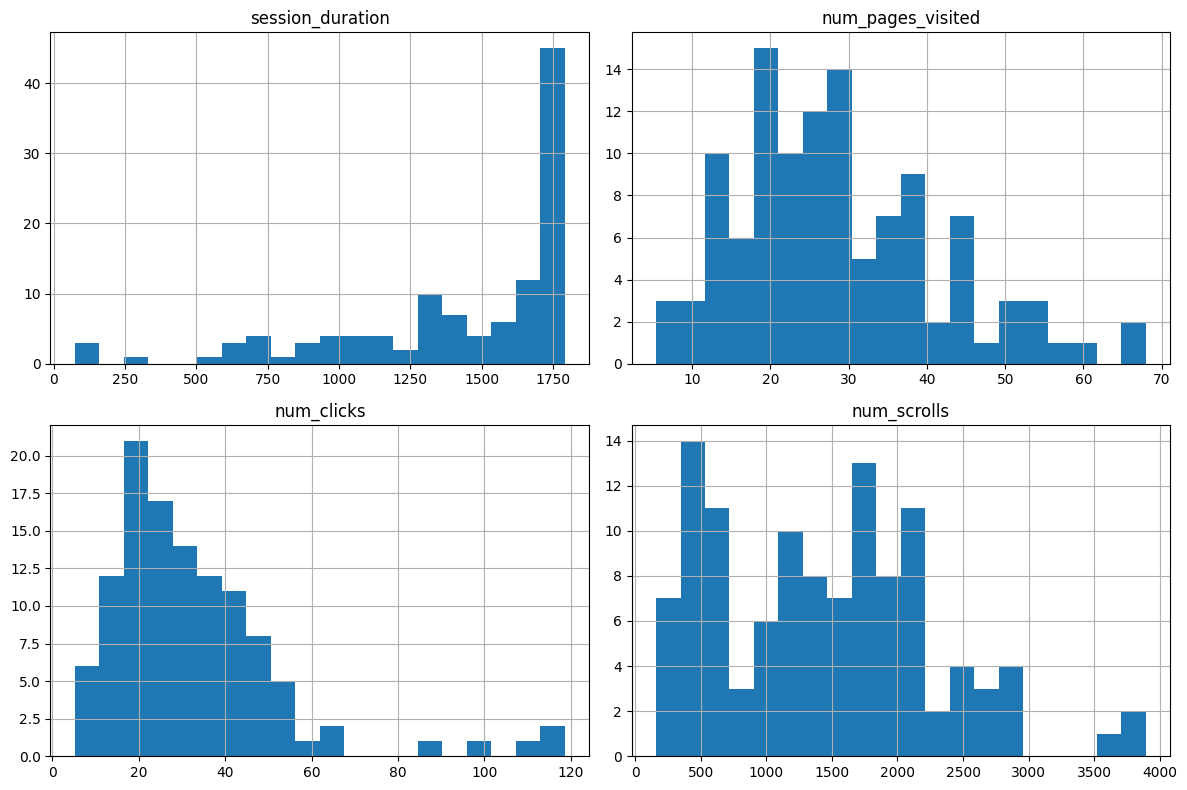

In [ ]:
df[numeric].hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

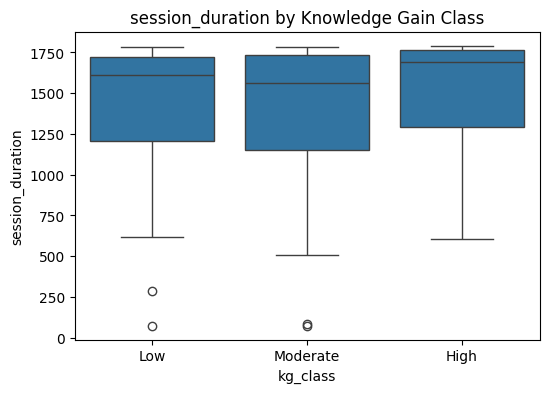

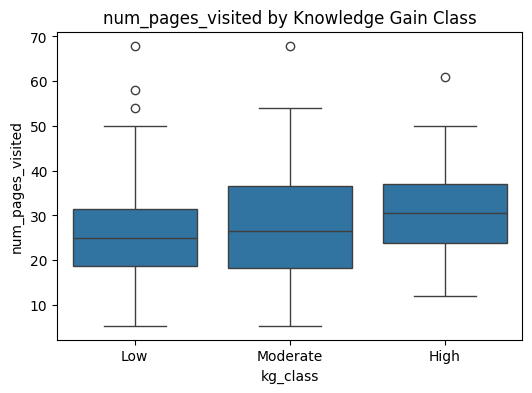

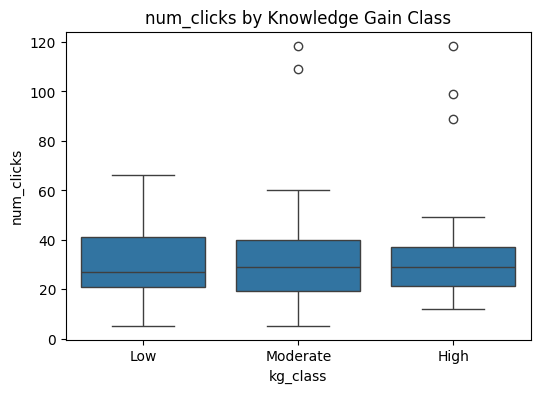

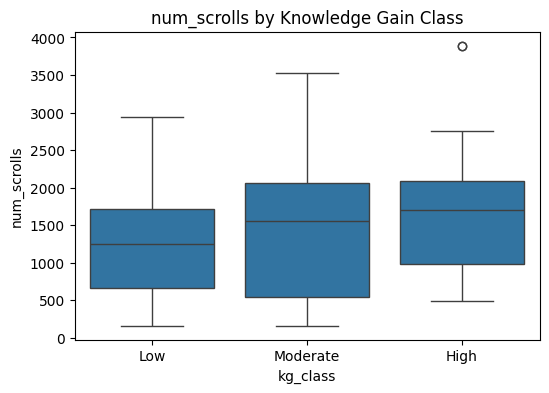

In [ ]:
for feat in numeric:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='kg_class', y=feat, data=df, order=['Low','Moderate','High'])
    plt.title(f"{feat} by Knowledge Gain Class")
    plt.show()

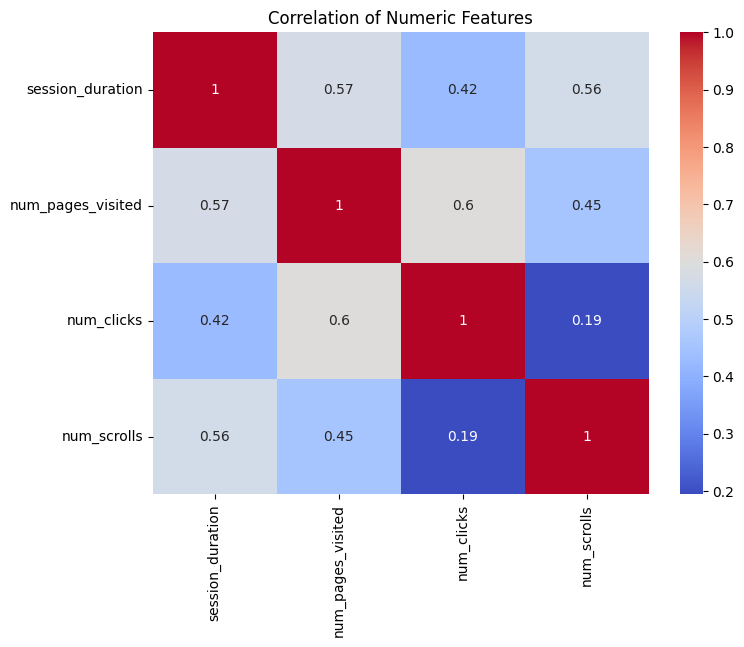

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation of Numeric Features")
plt.show()

In [ ]:
# Split
train_df, test_df = train_test_split(df, test_size=0.2,
                                     stratify=df['kg_class'],
                                     random_state=42)

In [ ]:
# Scale numeric features
scaler = StandardScaler()
train_df[numeric] = scaler.fit_transform(train_df[numeric])
test_df[numeric]  = scaler.transform(test_df[numeric])

In [ ]:
# One-hot encode categorical demographics
cat_feats = ['d_sex','d_field_of_study','d_lang']
train_df = pd.get_dummies(train_df,  columns=cat_feats, drop_first=True)
test_df  = pd.get_dummies(test_df,   columns=cat_feats, drop_first=True)

In [ ]:
# Align train/test columns
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

In [ ]:
print("Training set shape:", train_df.shape)
print("Test set shape:",     test_df.shape)

Training set shape: (91, 100)
Test set shape: (23, 100)


### Implementation using scikit-learn


In [ ]:
X_train = train_df.drop(columns=['p_id','kg_mc','kg_class']).values
X_test  = test_df.drop(columns=['p_id','kg_mc','kg_class']).values
y_train = le.transform(train_df['kg_class'])
y_test  = le.transform(test_df['kg_class'])

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_clf.fit(X_train, y_train)  [2]

DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                       random_state=1935803228)

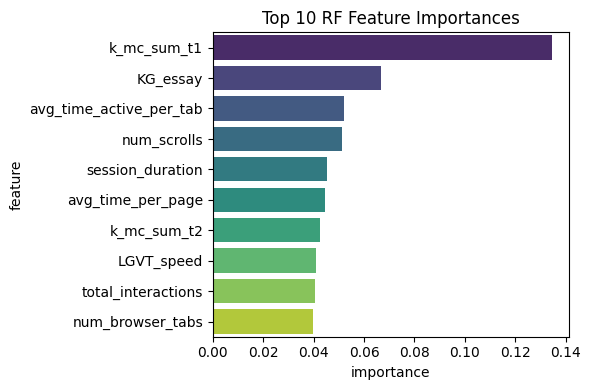

In [ ]:
# Top 10 Feature Importances
feat_names = train_df.drop(columns=['p_id','kg_mc','kg_class']).columns
importances = rf_clf.feature_importances_
imp_df = (
    pd.DataFrame({'feature': feat_names, 'importance': importances})
      .sort_values('importance', ascending=False)
      .head(10)
)

plt.figure(figsize=(6,4))
sns.barplot(x='importance', y='feature', data=imp_df, palette='viridis')
plt.title("Top 10 RF Feature Importances")
plt.tight_layout()
plt.show()

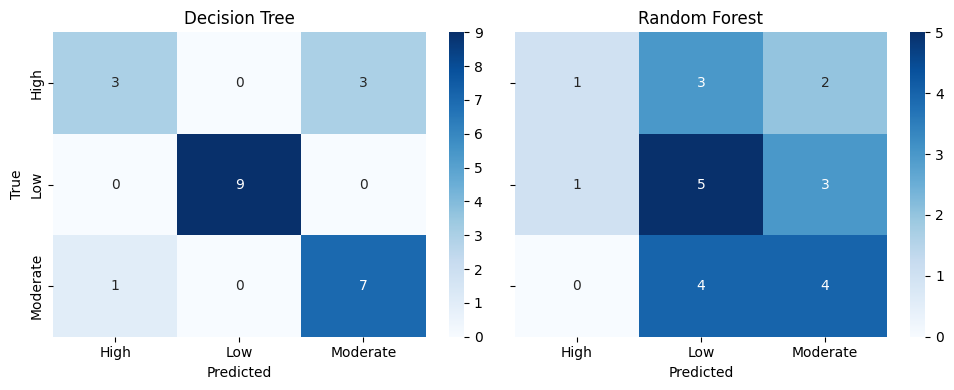

In [ ]:
# Confusion Matrices (DT vs RF)
fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)

# Decision Tree
cm_dt = confusion_matrix(y_test, clf.predict(X_test))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", ax=axes[0],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0].set_title("Decision Tree")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Random Forest
y_pred_rf = rf_clf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", ax=axes[1],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[1].set_title("Random Forest")
axes[1].set_xlabel("Predicted")

plt.tight_layout()
plt.show()

### Hyperparameter Tuning with GridSearchCV



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
  'n_estimators': [50, 100, 200],
  'max_depth': [None, 5, 10],
  'max_features': ['sqrt', 'log2', 0.5],
  'min_samples_leaf': [1, 2, 5],
  'class_weight': ['balanced', None]
}
gs = GridSearchCV(
  RandomForestClassifier(random_state=42),
  param_grid, cv=5, scoring='f1_macro', n_jobs=-1
)
gs.fit(X_train, y_train)
print("Best RF params:", gs.best_params_)
rf_best = gs.best_estimator_

Best RF params: {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 50}


In [ ]:
# Address Class Imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("Resampled dataset shape:", np.bincount(y_res))

Resampled dataset shape: [35 35 35]


In [ ]:
# Retrain Random Forest with best params on resampled data
rf_balanced = RandomForestClassifier(**gs.best_params_, random_state=42)
rf_balanced.fit(X_res, y_res)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.5,
                       min_samples_leaf=2, n_estimators=50, random_state=42)

In [ ]:
# Evaluate on original test set
y_pred_bal = rf_balanced.predict(X_test)
print("Balanced RF Accuracy:", accuracy_score(y_test, y_pred_bal))

Balanced RF Accuracy: 0.6956521739130435


In [ ]:
print(classification_report(y_test, y_pred_bal, target_names=le.classes_))

              precision    recall  f1-score   support

        High       1.00      0.50      0.67         6
         Low       0.70      0.78      0.74         9
    Moderate       0.60      0.75      0.67         8

    accuracy                           0.70        23
   macro avg       0.77      0.68      0.69        23
weighted avg       0.74      0.70      0.69        23



In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))

Confusion Matrix:
 [[3 1 2]
 [0 7 2]
 [0 2 6]]


## Part 3: Boosting Methods

Apply boosting (e.g., AdaBoost and XGBoost) to knowledge gain prediction and compare performance with the single decision tree (from Part 1b) and Random Forest (from Part 2).

In [ ]:
!pip install scikit-learn --upgrade

In [ ]:
import sklearn
print(sklearn.__version__)

1.6.1


In [ ]:
feat_names = train_df.drop(columns=['p_id','kg_mc','kg_class']).columns

### AdaBoost Implementation & Tuning

In [ ]:
# Base AdaBoost with decision stumps
ada = AdaBoostClassifier(
    n_estimators=50,
    learning_rate=1.0,
    random_state=42,
)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
print("AdaBoost (default) Accuracy:", accuracy_score(y_test, y_pred_ada))
print(classification_report(y_test, y_pred_ada, target_names=le.classes_))

AdaBoost (default) Accuracy: 0.6086956521739131
              precision    recall  f1-score   support

        High       1.00      0.17      0.29         6
         Low       0.86      0.67      0.75         9
    Moderate       0.47      0.88      0.61         8

    accuracy                           0.61        23
   macro avg       0.77      0.57      0.55        23
weighted avg       0.76      0.61      0.58        23



In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Hyperparameter grid search for AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator': [DecisionTreeClassifier(max_depth=1),
                      DecisionTreeClassifier(max_depth=2),
                      DecisionTreeClassifier(max_depth=3)]
}


gs_ada = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    param_grid_ada,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)
gs_ada.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'estimator': [DecisionTreeClassifier(max_depth=1),
                                       DecisionTreeClassifier(max_depth=2),
                                       DecisionTreeClassifier(max_depth=3)],
                         'learning_rate': [0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             scoring='f1_macro')

In [ ]:
print("Best AdaBoost params:", gs_ada.best_params_)

Best AdaBoost params: {'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


In [ ]:
# Evaluate tuned AdaBoost
ada_best = gs_ada.best_estimator_
y_pred_ada_best = ada_best.predict(X_test)
print("AdaBoost (tuned) Accuracy:", accuracy_score(y_test, y_pred_ada_best))
print(classification_report(y_test, y_pred_ada_best, target_names=le.classes_))

AdaBoost (tuned) Accuracy: 0.8260869565217391
              precision    recall  f1-score   support

        High       1.00      0.67      0.80         6
         Low       1.00      0.78      0.88         9
    Moderate       0.67      1.00      0.80         8

    accuracy                           0.83        23
   macro avg       0.89      0.81      0.83        23
weighted avg       0.88      0.83      0.83        23



### XGBoost Implementation & Tuning

In [ ]:
# Base XGBoost model
xgb_clf = xgb.XGBClassifier(
    num_class=3,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("XGBoost (default) Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

XGBoost (default) Accuracy: 0.8260869565217391
              precision    recall  f1-score   support

        High       1.00      0.67      0.80         6
         Low       0.89      0.89      0.89         9
    Moderate       0.70      0.88      0.78         8

    accuracy                           0.83        23
   macro avg       0.86      0.81      0.82        23
weighted avg       0.85      0.83      0.83        23



In [ ]:
# Hyperparameter grid search for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
gs_xgb = GridSearchCV(
    xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid_xgb, scoring='accuracy', cv=5, n_jobs=-1
)
gs_xgb.fit(X_train, y_train)
print("Best XGBoost params:", gs_xgb.best_params_)

Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [ ]:
# Evaluate tuned XGBoost
xgb_best = gs_xgb.best_estimator_
y_pred_xgb_best = xgb_best.predict(X_test)
print("XGBoost (tuned) Accuracy:", accuracy_score(y_test, y_pred_xgb_best))
print(classification_report(y_test, y_pred_xgb_best, target_names=le.classes_))

XGBoost (tuned) Accuracy: 0.7391304347826086
              precision    recall  f1-score   support

        High       0.75      0.50      0.60         6
         Low       0.89      0.89      0.89         9
    Moderate       0.60      0.75      0.67         8

    accuracy                           0.74        23
   macro avg       0.75      0.71      0.72        23
weighted avg       0.75      0.74      0.74        23



In [ ]:
from sklearn.metrics import f1_score

results = {
    'Model': ['DecisionTree','RandomForest','AdaBoost','AdaBoost (tuned)','XGBoost','XGBoost (tuned)'],
    'Accuracy': [
        dt_accuracy,
        rf_balanced.score(X_test, y_test),
        accuracy_score(y_test, y_pred_ada),
        accuracy_score(y_test, y_pred_ada_best),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_xgb_best)
    ],
    'Macro-F1': [
        f1_score(y_test, clf.predict(X_test), average='macro'),
        f1_score(y_test, rf_balanced.predict(X_test), average='macro'),
        f1_score(y_test, y_pred_ada, average='macro'),
        f1_score(y_test, y_pred_ada_best, average='macro'),
        f1_score(y_test, y_pred_xgb, average='macro'),
        f1_score(y_test, y_pred_xgb_best, average='macro')
    ]
}
pd.DataFrame(results)


,Model,Accuracy,Macro-F1
0,DecisionTree,1.000000,0.792593
1,RandomForest,0.695652,0.690058
2,AdaBoost,0.608696,0.548137
3,AdaBoost (tuned),0.826087,0.825000
4,XGBoost,0.826087,0.822222
5,XGBoost (tuned),0.739130,0.718519
